In [1]:
import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import glob
import os
from pathlib import Path
import tensorflow as tf

%matplotlib inline
plt.rcParams["figure.figsize"] = (7,5)

2022-03-14 15:57:00.003736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 15:57:00.004111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
models = (
    ["GarNet", "/eos/user/m/mushahid/cms-ad/src/output/test8", glob.glob("../signals/signals1/*")],
)

for model in models:
    model.append(h5py.File(model[1]+"/output.h5", 'r'))


features = ("η", "ϕ", "pT")
loss = tf.keras.losses.MeanSquaredError()

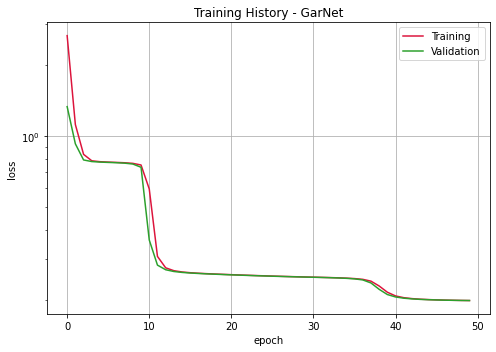

In [3]:
def plot_training_history(model_output, title, model_loc):
    loss = model_output['loss'][:]
    val_loss = model_output['val_loss'][:]
    
    plt.figure()
    plt.plot(loss, color="crimson")
    plt.plot(val_loss, color="tab:green")
    plt.title("Training History - %s"%title)

    plt.semilogy()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.grid(True)

    plt.savefig(model_loc+"/training.png")
    plt.show()

for model in models:
    plot_training_history(model[-1], model[0], model[1])

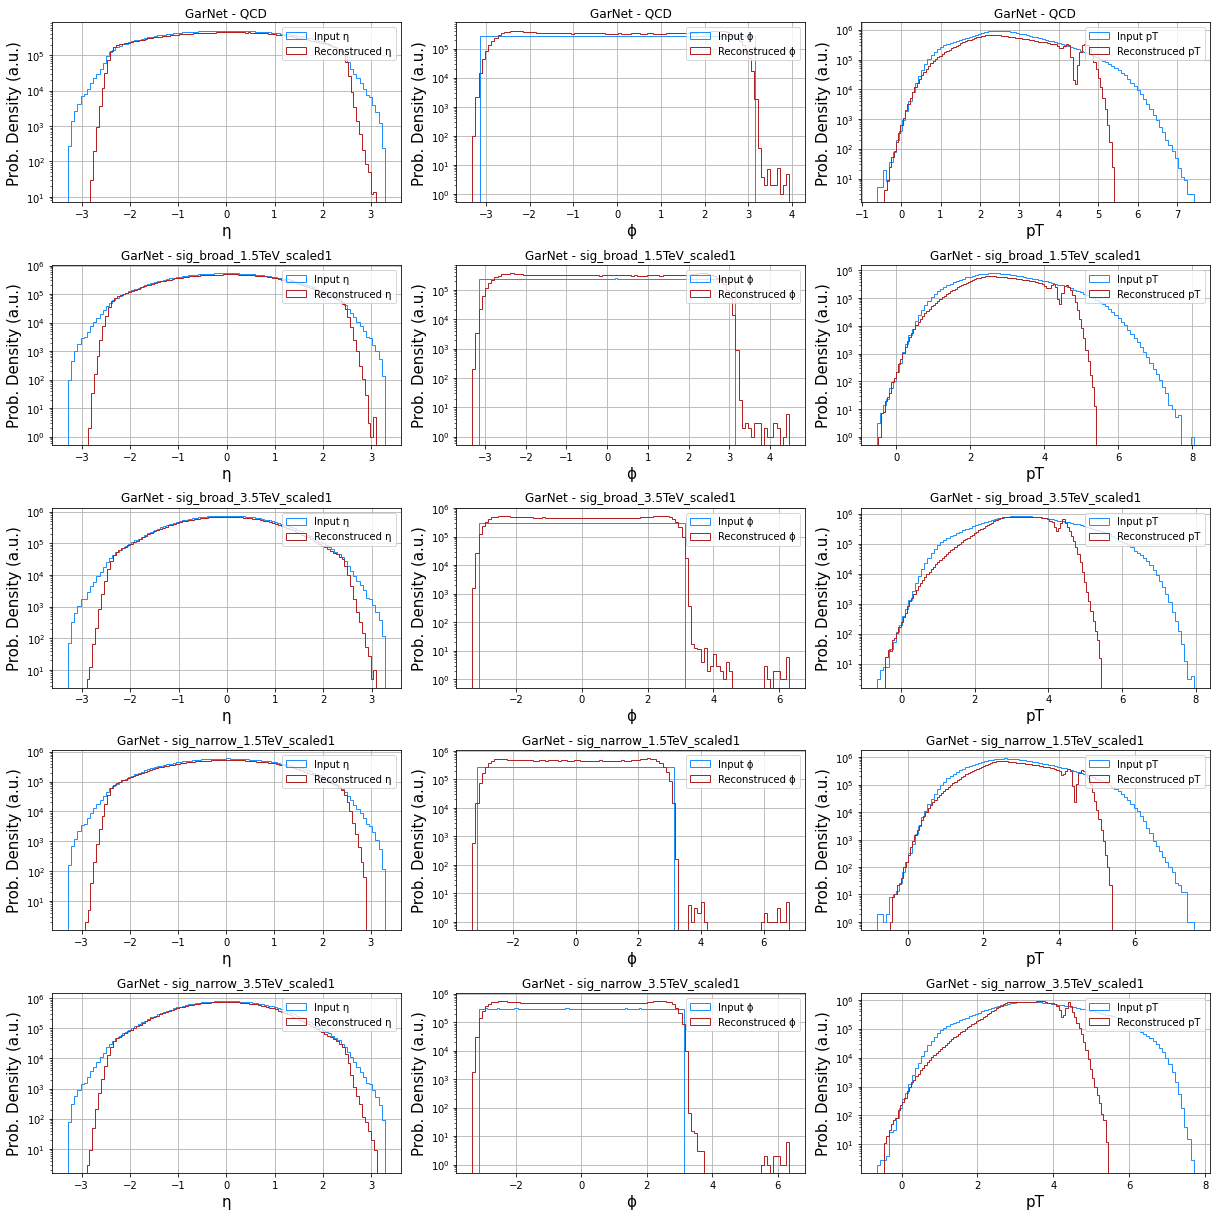

In [4]:
def plot_features1d(model_output, title, signals_loc, model_loc):

    fig, axs = plt.subplots(len(signals_loc)+1, len(features), figsize=(17,17))

    for i, f in enumerate(["QCD"]+signals_loc):
        if f == "QCD":
            input_data = model_output[f][()]
        else:
            input_data = h5py.File(f, 'r')["jetConstituentsList"][()]

        predicted_data = model_output["predicted_"+Path(f).stem][()]
        # predicted_data = np.expand_dims(np.reshape(predicted_data, (np.shape(predicted_data)[0],) + (16, 3)), axis=3)

        for j, feature in enumerate(features):

            ax = axs[i][j]
            
            ax.hist(input_data[:,:,j].flatten(), 100, label="Input %s"%feature, density=False, 
                histtype='step', fill=False, linewidth=1, color="dodgerblue")

            ax.hist(predicted_data[:,:,j].flatten(), 100, label="Reconstruced %s"%feature, density=False,
                histtype='step', fill=False, linewidth=1, color="firebrick")
            
            ax.set_yscale('log', nonpositive='clip')     
            ax.set_xlabel(feature, fontsize=15)
            ax.set_ylabel('Prob. Density (a.u.)', fontsize=15)
            ax.set_title("%s - %s"%(title, Path(f).stem))
            ax.grid(True)
            ax.legend(loc="upper right")

    fig.tight_layout()
    plt.savefig(model_loc+"/recon1d.png")
    plt.show()

for model in models:
    plot_features1d(model[-1], model[0], model[2], model[1])

In [ ]:
def plot_features2d(model_output, title, signals_loc, model_loc):

    fig, axs =  plt.subplots(len(signals_loc)+1, len(features), figsize=(17,17))

    for i, f in enumerate(["QCD"]+signals_loc):
        if f == "QCD":
            input_data = model_output[f][()]
        else:
            input_data = h5py.File(f, 'r')["jetConstituentsList"][()]

        predicted_data = model_output["predicted_"+Path(f).stem][()]

        for j, feature in enumerate(features):

            ax = axs[i][j]

            x = predicted_data[:,:,j].flatten()
            y = input_data[:,:,j].flatten()
            
            plot = ax.hist2d(x, y, bins=100, density=False)
            
            ax.set_xlabel("Reconstructed {}".format(feature), fontsize=15)
            ax.set_ylabel('Input {}'.format(feature), fontsize=15)
            ax.set_title("%s - %s"%(title, Path(f).stem))
            fig.colorbar(plot[3], ax=ax)

    fig.tight_layout()
    plt.savefig(model_loc+"/recon2d.png")
    plt.show()

for model in models:
    plot_features2d(model[-1], model[0], model[2], model[1])

2022-03-14 16:00:00.232205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 16:00:00.232509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 16:00:00.267397: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxplus8s14.cern.ch): /proc/driver/nvidia/version does not exist
2022-03-14 16:00:00.399590: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 16:00:01.127510: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33231532

TypeError: Scalar tensor has no `len()`

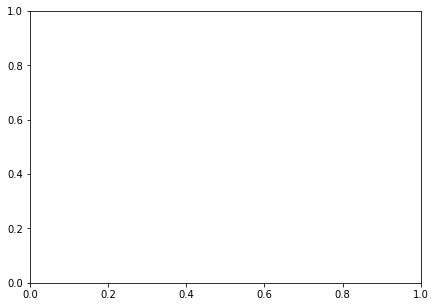

In [5]:
def ae_loss(model_output, title, signals_loc, model_loc):
    plt.figure()

    for f in ["QCD"]+signals_loc:
        
        if f == "QCD":
            fill, alpha = [True, 0.2]
            inval = model_output[f][()]
            name = f
        else:
            fill, alpha = [False, 1]
            inval = h5py.File(f, 'r')["jetConstituentsList"][()]
            name = Path(f).stem

        outval = model_output["predicted_"+name][()]

        lossQCD = loss(np.reshape(inval, [-1, 16*3*1]), np.reshape(outval, [-1, 16*3*1]))
        maxScore = np.max(lossQCD)

        # plot AE Loss
        plt.hist(lossQCD, bins=100, label=name, density=True, range=(0, maxScore), 
                 histtype='step', fill=fill, alpha=alpha, linewidth=1.5)

    plt.semilogy()
    plt.title(title)
    plt.xlabel("AE Loss")
    plt.ylabel("Probability (a.u.)")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.savefig(model_loc+"/loss.png")
    plt.show()

for model in models:
    ae_loss(model[-1], model[0], model[2], model[1])

In [6]:
def metrics(model_output, signals_loc):
    lossQCD = loss(np.reshape(model_output["QCD"][()], [-1, 16*3*1]), np.reshape(model_output["predicted_QCD"][()], [-1, 16*3*1]))
    
    metrics = []
    
    for f in signals_loc:
        name = Path(f).stem
        
        anomaly = h5py.File(f, 'r')["jetConstituentsList"][()]
        loss_anomaly = loss(np.reshape(anomaly, [-1, 16*3*1]), np.reshape(model_output["predicted_"+name][()], [-1, 16*3*1]))

        true_val = np.concatenate((np.ones(loss_anomaly.shape[0]), np.zeros(lossQCD.shape[0])))
        pred_val = np.concatenate((loss_anomaly, lossQCD))

        fpr, tpr, threshold = roc_curve(true_val, pred_val)
        auc_data = auc(fpr, tpr)
        
        metrics.append([name, fpr, tpr, auc_data])
    
    return np.array(metrics, dtype=object)

In [7]:
def plot_roc(model_output, title, signals_loc, model_loc):
    for sig_metrics in metrics(model_output, signals_loc):

        plt.plot(sig_metrics[2], sig_metrics[1], label="%s (auc = %.1f%%)"%(sig_metrics[0], sig_metrics[3]*100.))

        plt.semilogy()
        plt.title(title)
        plt.xlabel("sig. efficiency")
        plt.ylabel("bkg. mistag rate")
        plt.grid(True)
        plt.legend(loc="lower right")
         
    plt.savefig(model_loc+"/roc.png")
    plt.show()
    
for model in models:
    plot_roc(model[-1], model[0], model[2], model[1])

2022-03-14 16:00:59.105489: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 332315328 exceeds 10% of free system memory.


IndexError: list index out of range

In [ ]:
def ratios(base_output, signals_loc):
    model_output = h5py.File(base_output, "r")
    base = metrics(model_output, glob.glob(signals_loc))
    plt.hlines(1, 1, 17, linestyles='--', color='#ef5675', linewidth=1.5)
    plt.ylim(0.7, 1.3)

    for i in range(2, 17, 2):
        model_output_qp = h5py.File("output/cnn_qp"+str(i)+"/output.h5", "r")
        bits = metrics(model_output_qp, signals_loc)
        plt.scatter([i]*len(base), bits[:, 3]/base[:, 3])

    # plt.legend()
    plt.xlabel("Bit Width")
    plt.ylabel("Sig. AUC / Base AUC")
    plt.title("Bit Ratios")
    plt.show()

# ratios("../output/cnn/output.h5", "../signals_old/*")